# Measuring the Entropy of English Language

In this notebook we will reproduce a classic application of the "information theory", developed by Claude Shannon in his seminal paper __"A Mathematical Theory of Communication"__ [[1](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)], in which we compute how much information the written english language contains as described by Shannon in his paper entitled __"Prediction and Entropy of Printed English"__ [[2](https://www.princeton.edu/~wbialek/rome/refs/shanno)].

In [1]:
##########################################################################
# Important packages
##########################################################################
import numpy             as np 
import matplotlib.pyplot as plt
import pandas            as pd
import glob
import re
from   nltk              import ngrams, FreqDist

##########################################################################
# Plots configuration
##########################################################################
plt.xkcd()

### A brief review of the Entropy [[3](https://www.scielo.br/pdf/rbef/v41n2/1806-9126-RBEF-41-2-e20180197.pdf)]

Before going any further let's revise the main quantite of information theory, the entropy: $H(X)$. In a straightfoward definition the entropy quantifies the amount of uncertainty associated to a given random variable $X$, and it is the average of another quantity called information content $h(x_i)$. Note that $h(x_i)$ is a measure of uncertainty (or surprisal) associated to a single outcome of $X$, here denoted by $x_i$. 

But, how to define $h(x_i)$? Intuitivelly, one could associate the amount of unecertainty of an outcome $x_i$ to the inverse of its probability $p(x_i)$, i.e., the rare the event is the more information one gets by observing this outcome (or more surprised the observer gets, which is why it is also called surprisal). However, this definition carries a few problems, for example, for $p(x_i)\rightarrow 0$, the surprisal would go toward infinity $h(x_i)\rightarrow \infty$. In order to satisfy the following properties [[4](http://www.mtm.ufsc.br/~taneja/book/node6.html)]:

1. $H(X)$ is continuous;
2. $H(X)$ increases monotonically with the number of outcomes $n$: $\{p(x_1), \dots, p(x_n) \}$;
3. $H(X)$ is additive $H(XY) = H(X)+H(Y)$.

We define the surprisal as:

$h(x_i) = \log_{b}\left(\frac{1}{p(x_i)}\right)$,

Consequently, the entropy of $X$ in given by:

$H(X) = -\sum_{i} p(x_i)\log_{b}(p(x_i))$.

Using this definition the maximum amount of uncertainty of a random variable occurs when all its outcomes are equaly probable (picture yourself trying to guess which outcome will result from tossing a fair dice of $1000$ faces let's say, hard isn't it? But let's say that the dice is biased towards even numbers greather that $500$ it starts to get easier to guess!). For $n$ equaly probable outcomes, we have: $p(x_1) = ... = p(x_n) = 1/n$, therefore:

$H(X) = \log_{b}(n)$.

It is easy to see from the equation above that $H(X)$ satsfies conditions (1), and (2). On the equations above if the base of the logarithm $b=2$, the entropy is defined in __bits__ (for $b = e$, in __nats__). Let's apply exponential of $2$ on both sides of the equation above:

$n = 2^{H(X)}$,

for $H(X) = 1$ bit, we get $n = 2$, therefore $1$ bit is the amount of information necessary to choose between two equaly probable outcomes.

To illustrate, let's plot $h(x_i)$, and $H(x)$ as a funtion of the probability for a variable with two possible outcomes with probabilities $p$, and $q$ with $p = 1 - q$ (note that $H(X)$ is maximum for $p=q$, indicated by the red dashed line in the plot). 

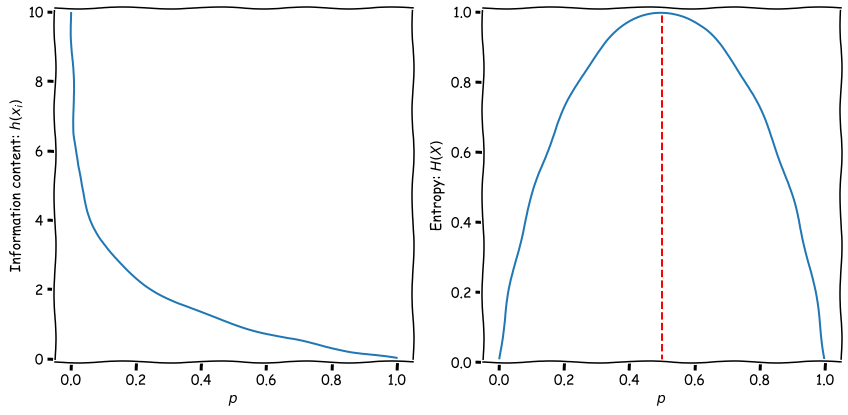

In [30]:
# Probability p
p = np.linspace(0.001, 0.999, 100)
# Surprisal
h = np.log2(1/p)
# Entropy
H = -p*np.log2(p) - (1-p)*np.log2((1-p))
# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(p, h)
plt.ylim([-0.1, 10.1])
plt.ylabel('Information content: $h(x_i)$')
plt.xlabel('$p$')
plt.subplot(1,2,2)
plt.plot(p, H)
plt.vlines(0.5, 0, 1, 'r', '--')
plt.ylabel('Entropy: $H(X)$')
plt.xlabel('$p$')
plt.ylim([0, 1.01])
plt.tight_layout()

Let's define a Python class named Shannon, that will be responsible to compute entropies for us! 

In [74]:
##########################################################################
# Define class Shannon, it will have a method to compute entropy from 
# a list of probabilities
##########################################################################
class Shannon():
    
    def __init__(self, ):
        None

    ##########################################################################
    # This function computes the surprisal given the probability of the outcome
    ##########################################################################
    def compute_surprisal(self, p_xi):
        return np.log2(1/p_xi)
    
    ##########################################################################
    # This function computes the entropy given a discrete probability dist.
    ##########################################################################
    def compute_entropy(self, p_x):
        return -np.sum(p_x * np.log2(p_x))

### Reading, and pre-processing the dataset

Ok, but how can we measure the amount of information contained in printed english language? At this point is clear that we should use Shannon's entropy, but it is also necessery to use a data-set containing english texts so we can extract the statistics necessary to compute the entropy. In this notebook we will be using the Guttenberg project dataset [[5](http://www.gutenberg.org/)], this dataset contains thousands of english books in ".txt" format, and can be downloaded either from my drive account [[6](https://drive.google.com/drive/folders/1duR44cfHvb95J_FrfGFaqA_joL5LFNaP?usp=sharing)], or on this web page [[7](https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html)].

For our purposes, we will only consider the $26$ letters of the english alphabet, i.e., numbers, and special characters linebreaks, spaces, and apostrophe have to be removed from the text files. Let's beggin by retrieving the files (books) names from "Guttenberg/txt".

In [32]:
##########################################################################
# Path where the books in TXT format are located
##########################################################################
path = 'Gutenberg/txt'

##########################################################################
# Getting file names (book titles)
##########################################################################
f_names = []
for file in glob.glob(path + "/*.txt"):
    f_names.append(file)

Let's print a random book name from the dataset just to check!

In [40]:
print(f_names[np.random.randint(0, len(f_names),10)[0]])

Gutenberg/txt\Joseph Conrad___Falk.txt


Now I'll define a class called BookWorm containing functions to read and pre-process the text file for our purposes

In [57]:
##########################################################################
# Define class bookwork, to read and prepare the text for us!
##########################################################################
class BookWorm():
    
    def __init__(self,):
        None

    ##########################################################################
    # This function you read the book file given its path
    ##########################################################################
    def read_book(self, path):
        with open(path, 'r') as file_object:
            book = file_object.read()
        return book

    ##########################################################################
    # This function receives the raw text and remove special characters
    ##########################################################################
    def remove_special(self, book):
        final = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in book.split("\n")]
        return final

    ##########################################################################
    # This function vectorizes the book , i.e. concatenates every sentence 
    # in a single list each sentence is separated by a space
    ##########################################################################
    def vectorize(self, text_no_special, remove_spaces = False):
        text = ''
        for sentence in text_no_special:
            text = text + ' ' + sentence
        text = re.sub(' +', ' ', text) # Removes double spaces
        if remove_spaces == True:
            text = text.replace(" ", "")
        if text[0] == ' ':
            return text[1:].lower() # Rerurn only in lowercase
        else:
            return text.lower() # Rerurn only in lowercase
    
    def remove_numbers(self, text_vectorized):
        res = ''.join([i for i in text_vectorized if not i.isdigit()]) 
        return res

For our example we are going to load "Robson Crusoe" by Daniel Defoe. To do so we first instatiate a BookWorm object and use its functions to process the text.

In [215]:
# Instatiate a BookWork object
bw = BookWorm()
# Reading "Robison Crusoe"
book     = bw.read_book('Gutenberg/txt/Daniel Defoe___The Life and Adventures of Robinson Crusoe (1808).txt')
# Removing special characters (Book with no special characters)
book_ns  = bw.remove_special(book)
# Vectorizing book
book_v   = bw.vectorize(book_ns, remove_spaces = True)
# Remove numbers
raw_text = bw.remove_numbers(book_v)

Let's compare the orinal text book with the final text after processing it:

In [216]:
print('#####################################################################################')
print('                               Original book text file')
print('#####################################################################################\n')
print(book[:1000])

#####################################################################################
                               Original book text file
#####################################################################################


THE LIFE AND ADVENTURES OF ROBINSON CRUSOE

by DANIEL DE FOE

London.

18O8







[Illustration: I had one labour to make me a Canoe,
which at last I finished.]




THE LIFE OF DE FOE


Daniel De Foe was descended from a respectable family in the county of
Northampton, and born in London, about the year 1663. His father, James
Foe, was a butcher, in the parish of St. Giles's, Cripplegate, and a
protestant dissenter. Why the subject of this memoir prefixed the _De_
to his family name cannot now be ascertained, nor did he at any period
of his life think it necessary to give his reasons to the public. The
political scribblers of the day, however, thought proper to remedy this
lack of information, and accused him of possessing so little of the
_amor patriae_, as t

In [217]:
print('#####################################################################################')
print('                              Processed book text file')
print('#####################################################################################\n')
print(raw_text[:1000])

#####################################################################################
                              Processed book text file
#####################################################################################

thelifeandadventuresofrobinsoncrusoebydanieldefoelondonoillustrationihadonelabourtomakemeacanoewhichatlastifinishedthelifeofdefoedanieldefoewasdescendedfromarespectablefamilyinthecountyofnorthamptonandborninlondonabouttheyearhisfatherjamesfoewasabutcherintheparishofstgilesscripplegateandaprotestantdissenterwhythesubjectofthismemoirprefixedthedetohisfamilynamecannotnowbeascertainednordidheatanyperiodofhislifethinkitnecessarytogivehisreasonstothepublicthepoliticalscribblersofthedayhoweverthoughtpropertoremedythislackofinformationandaccusedhimofpossessingsolittleoftheamorpatriaeastomaketheadditioninorderthathemightnotbetakenforanenglishmanthoughthisideacouldhavehadnootherfoundationthanthecircumstanceofhishavinginconsequenceofhiszealforkingwilliamattackedtheprejudic

No the fun beggins, if we want to compute the amount of information, considering only the $26$ letters of the alphabet a first approach is to consider that each letter occurs randomly with a given frequency, and use the frequency distribution of the letters to compute the entropy.

The maximum entropy we can possibly have in this case is:

$H(X) = \log_{2}(26) \approx 4.7 $ bits!

But certainly, the letters are not all equaly probable.

We can find the letter frequency in our sample text "Robson Cruso" by using the "Counter" method as bellow:

In [218]:
from collections import Counter
# Computing the frequency of letters
letter_frequency = Counter(raw_text)

The probability of ocurrence of each letter is just the letter_frequency divided by the total amount of letters in the text. This is called the "naive" or "plug-in" estimator of entropy. We first compute the probabilites of each outhcome with:

$p = \frac{\#\text{ Outcome } i}{\#\text{ Outcomes}}$

And then "plug-it" in the entropy formula.

In [219]:
# Computing probability of each outcome (letter)
p_letter = np.array(list(letter_frequency.values())) / np.array(list(letter_frequency.values())).sum()

The entropy can be computed with Shannon's help, first we instantiate a Shannon object and then use its method "compute_entropy" for the probabilities found above!

In [220]:
# Instantianting object
shannon = Shannon()
# Computing letter entropy
H_letter = shannon.compute_entropy(p_letter)
print('The entropy of english using letter frequencie is: ' + str(H_letter) + ' bits')

The entropy of english using letter frequencie is: 4.161373017338991 bits


Next, let's plot the histogram of letter probabilities and it's entropy above the graph.

Text(0.5, 1.0, 'Entropy ~ 4.16 bits')

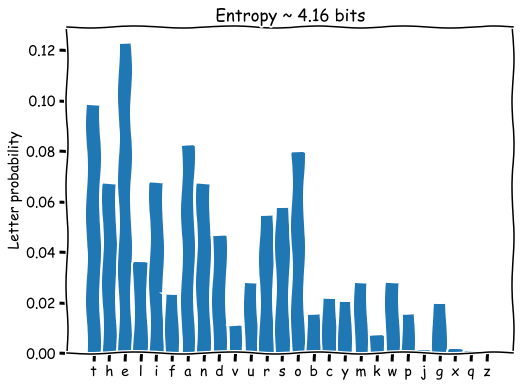

In [221]:
plt.figure(figsize=(8,6))
plt.bar(range(26), p_letter)
plt.xticks(range(26), letter_frequency.keys())
plt.ylabel('Letter probability')
plt.title('Entropy ~ ' + str(np.round(H_letter,2)) + ' bits')

### Improving our computation of the information contained in english text

As already mentioned, the letters are certainly not equaly probable as shown by the plot above (__E__ is the letter that appears the most in english as you may know), nonetheless the entropy obtained by this method ($4.16$ bits) is pretty close to the maximum entropy of $4.70$ bits!

Well, but how can we improve our calculation? That is the whole point of Shannon's already mentioned paper __"Prediction and Entropy of Printed English"__, the ideia of computing the entropy using the letter frequency is a pretty naive one, because there is some conditional structure in the order of appearence of letters and words, i.e., the appearence of a given letter on the text is also dependent on the letters that precede it. 

You can easily note this, suppose that I start to say: __Once upon a time in__, even though I haven't completed the sentence you probabaly would guess the next word in it as being __the__ (possibbly __west__, or __hollywood__ if you are a fan of cinema). And the more words I give you easier it gets to predict the next one.

On the other hand, if you generate a text by using the frequencies we have found above it will certainly end up being a total non-sense (unless you do it for a REALLY long time [[8](https://en.wikipedia.org/wiki/Infinite_monkey_theorem)] or if you have an infinite amount of books [[9](https://maskofreason.files.wordpress.com/2011/02/the-library-of-babel-by-jorge-luis-borges.pdf)]). So to improve our estimation of the information contained in written english we have to consider not only the probability of each letter, but also the conditional probabilities of blocks of letters called __n-grams__.

In short, a $n$-gram is a block of $n$ letters so if I have the following sentence __onceuponatime__, and divide it in $2$-grams (bi-grams), I would end up with the blocks: __on__, __nc__, __ce__, ..., __me__ (considering a stride of one).

In his paper, Shannon defined the $n$-gram entropy as:

$F_{n} = -\sum_{i,j} p(b_{i},j)\log_{2}p(j|b_{i})$.

Where, $b_{i}$ is a block of $n-1$ letters, hence a (n-1)-gram, p(b_{i},j) is the joint probability of letter $j$, and the block $b_{i}$, and $p(j|b_{i})$ is the conditional probability of the letter $j$ given the block $b_{i}$.

Using the relation $p(j|b_{i}) = p(b_{i},j)/p(b_{i})$, we can rewrite $F_{n}$ as:

$F_{n} = -\sum_{i,j} p(b_{i},j)\log_{2}p(b_{i},j) + \sum_{i} p(b_{i})\log_{2}p(b_{i})$.

This equation quantifies the uncertaint of the next letter or word $j$ given the preceding block $b_{i}$ (like the example I gave above using the sentence __Once upon a time in__, as we increase the preceding block our uncertainty reduces).

The entropy of the english language can be then computed by taking the limit:

$H = \lim_{n \rightarrow \infty} F_{n}$.

As we increase $n$, $H$ gets smaller because of the intrinsic redundancy contained in the text imposed by the constrains that exists between letters, usign Shannon's words:

`"The redundancy, on the other hand, measures the amount of constraint imposed on a text in the language due to its statistical structure, e.g., in English the high frequency of the letter £, the strong tendency of H to follow T or of V to follow Q."`

In terms of coding the entropy computed to the english letter is the average numbers of $0$ and $1$ digits used to represent each letter in a Huffman coding sheme [[10](https://en.wikipedia.org/wiki/Huffman_coding)].

Finally, let's consider the cases for $n=1, 2, 3$, we will have:

$F_{1} = -\sum_{i} p(i)\log_{2}p(i)$, 

which is simply the entropy of english letter we have computed above $F_{1} \approx 4.16$ bits.

$F_{2} = -\sum_{i,j} p(i,j)\log_{2}p(i,j) + \sum_{i} p(i)\log_{2}p(i)$,

and

$F_{3} = -\sum_{i,j,k} p(i,j,k)\log_{2}p(i,j,k) + \sum_{i,j} p(i,j)\log_{2}p(i,j)$.

In general $F_{n}$ is the sum of the joint entropy for the $n$-grams (p($n$-gram)) plus the joint entropy for the $(n-1)$-grams (p($(n-1)$-gram)). Where, $p($n$-gram)$ is the frequency distribution of each block of size $n$.

To create the $n$-grams for our text we can use the Natural Language Toolkit (nltk) in python, to compute $F_{n}$ we can come up with a recurssive funtion that will do the work for us.

In [222]:
# Importing the Natural Language Toolkit
import nltk #import ngrams, FreqDist

In [223]:
##########################################################################
# This function computes F_n given the text and the size of the n-grams
##########################################################################
def compute_Fn(text, n):
    shannon = Shannon()
    if n == 1:
        # Create 1-gram
        ngram  = nltk.ngrams(text, n)
        # Compute frequency of each letter
        fdist = nltk.FreqDist(ngram) 
        p  = np.array(list(fdist.values())) / np.array(list(fdist.values())).sum()
        return shannon.compute_entropy(p)
    else:
        # Create (n-1)-gram
        nm1gram  = nltk.ngrams(text, n-1)
        # Compute frequency of each letter
        fdist1 = nltk.FreqDist(nm1gram) 
        p1  = np.array(list(fdist1.values())) / np.array(list(fdist1.values())).sum()
        # Create n-gram
        ngram  = nltk.ngrams(text, n)
        # Compute frequency of each letter
        fdist2 = nltk.FreqDist(ngram) 
        p2  = np.array(list(fdist2.values())) / np.array(list(fdist2.values())).sum()
        return shannon.compute_entropy(p2) - shannon.compute_entropy(p1)

Let's compute $F_1$, $F_{2}$, and $F_{3}$ for our text and compare with the values in Shannon's paper:

In [224]:
F1 = compute_Fn(raw_text, 1)
F2 = compute_Fn(raw_text, 2)
F3 = compute_Fn(raw_text, 3)
# Our result
F         = np.round(np.array([F1, F2, F3]), 2)
# Shannon's result
F_shannon = np.array([4.14, 3.56, 3.3])
data = pd.DataFrame(np.array([F, F_shannon]).T, columns=['Us', 'Shannon'])
data

,Us,Shannon
0,4.16,4.14
1,3.54,3.56
2,3.03,3.30


Despite being very close to Shannon's results for $n=1$, and $n=2$, the value for $n=3$ is different, carefull inspections of Shannon's paper reviews that for the $3$-grams he actually does not include trigams bridging words:

`"In this calculation the trigram table² used did not take into account trigrams bridging two words, such as WOW and OWO in TWO WORDS. To compensate partially for this omission, corrected trigram probabilities p(i,j,k) were obtained from the probabilities p'(i,j,k)..."`

What happens if we plot for $F_n$ for $n$ up to 20, for instance?

In [225]:
F = []
n = range(1,21)
for n_ in n:
    F.append( compute_Fn(raw_text, n_) )

Text(0.5, 0, 'n')

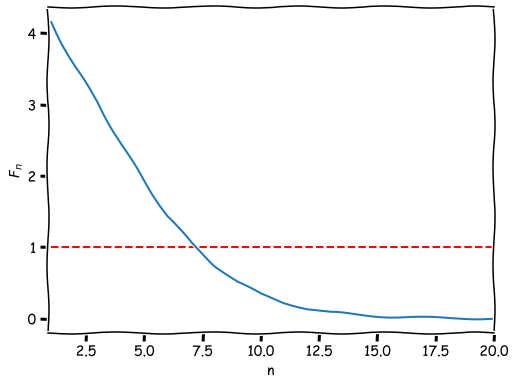

In [226]:
plt.figure(figsize=(8,6))
plt.plot(n, F)
plt.hlines(1, 1,20, 'r', '--')
plt.xlim(0.85,20)
plt.ylabel('$F_{n}$')
plt.xlabel('n')

By the analysis of the graph above, one can see that $F_{n}$ rapdly decreases below $1$ bit and tends to zero for higher $n$ (This was observed elsewhere [[11](https://arxiv.org/ftp/arxiv/papers/0911/0911.2284.pdf)]). As we increase $n$, then number of differen $n$-grams increase and we end up with a poor estimation of the probabilities for each of them. One way to check this is the average count of each $n$-gram as a function of $n$:

In [191]:
number_of_ngrams = []
for n_ in n:
    ngram  = nltk.ngrams(raw_text, n_)
    fdist = nltk.FreqDist(ngram) 
    number_of_ngrams.append( np.mean(list(fdist.values())) )

Text(0.5, 0, 'n')

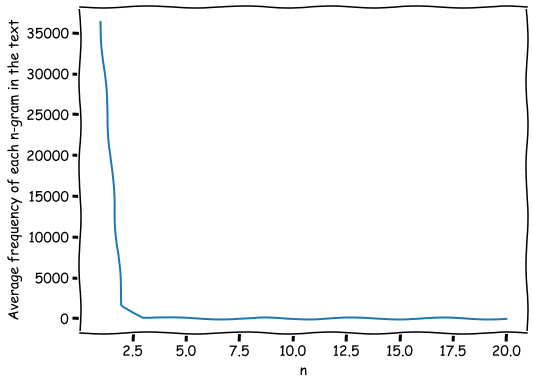

In [193]:
plt.figure(figsize=(8,6))
plt.plot(n, number_of_ngrams )
plt.ylabel('Average frequency of each n-gram in the text')
plt.xlabel('n')

As we can see the average quickly drops toward zero, which may imply that the estimate probability is wrong due to undersampling. 

Even using a bigger text "Guttenberg/txt/big.txt" you will see that this pratcally does not change. Lastly, in his paper Shannon measure the entropy of words, by count not the frequency of letters but words in the text. To do this we will use a bigger text file, mentioned above "big.txt". After loading the book we can easily do this as bellow:

In [295]:
# Instatiate a BookWork object
bw = BookWorm()
# Reading "Robison Crusoe"
book     = bw.read_book('Gutenberg/txt/big.txt')
# Removing special characters (Book with no special characters)
book_ns  = bw.remove_special(book)
# Vectorizing book
book_v   = bw.vectorize(book_ns, remove_spaces = False)
# Remove numbers
raw_text = bw.remove_numbers(book_v)

Next, let's assing a rank for each word, in such a way that the most frequent word will have rank $1$, the second most frequent rank $2$, and goes on.

In [304]:
# Getting words and word frequencies
words           = raw_text.split()
words_frequency = Counter(words)

In [314]:
# Getting words list, count list, and the respective probability
word_list  = np.array( list(words_frequency.keys()) )
count_list = np.array( list(words_frequency.values()) )
p_words    = count_list / count_list.sum()

In [315]:
# Sorting from highest to lowest probabilities
p_sorted  = np.sort(p_words)[::-1]
# Index of words oredere from bigger to lower rank
idx       = np.argsort(p_words)[::-1]
# Rank
rank      = np.arange(1, len(idx)+1)

Now lets print the $5$ most frequent words in the texts and its respective probability.

In [316]:
df_words = pd.DataFrame(np.array([word_list[idx], np.round(p_sorted,4)]).T, columns = ['Words', 'Frequency'])
df_words.head()

,Words,Frequency
0,the,0.0724
1,of,0.0362
2,and,0.0347
3,to,0.026
4,in,0.0199


The most frequent word in the text used is "the", followed by "of", and "and", which is the equal to what was reported elsewere:

`"the most frequently occurring word, "the", accounts for nearly 7% of all the words (69,971 out of slightly over 1 million)...  the second-place word "of" accounts for slightly over 3.5% of words (36,411 occurrences), followed by "and" (28,852)."`

If we plot the probability of each word as a function of its rank in a loglog graph, we will observe that the probability of a given word is inversely proportional to its rank:

$p(\rm{word}) \propto \frac{1}{\rm{rank}}$

This is known as "Zipf's law" [[12](https://simple.wikipedia.org/wiki/Zipf%27s_law#:~:text=Zipf's%20law%20states%20that%20given,rank%20in%20the%20frequency%20table.&text=True%20to%20Zipf's%20Law%2C%20the,%22and%22%20(28%2C852).)] (there is also this nice video on this subject [[13](https://www.youtube.com/watch?v=fCn8zs912OE&list=LL0XisOZJLTWrD0kNwlRoRUg&index=708)]).

Bellow, we plot the aformentioned graph:

Text(0.5, 0, 'Rank')

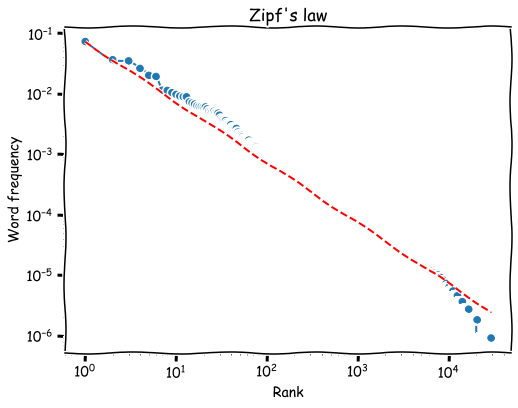

In [319]:
plt.figure(figsize=(8,6))
plt.loglog(rank, p_sorted, 'o-')
plt.plot(rank, p_sorted[0]/rank, 'r--')
plt.title('Zipf\'s law')
plt.ylabel('Word frequency')
plt.xlabel('Rank')

What Shannon does in his paper is compute the entropy of words using the distribution above, and take the ratio between the entropy found and the average length of english words, in his paper he uses the value 4.5, but let's compute it ourselfs. Then, let's compute the average length of english words.

In [328]:
avg_word_length = 0
for word in words:
    avg_word_length += len(word)
avg_word_length = avg_word_length / len(words)
print('Average word length: ' + str(avg_word_length))

Average word length: 4.595575781702374


Pretty close to Shannon's! Now let's compute the entropy of words:

In [342]:
H_words = np.round( shannon.compute_entropy(p_sorted), 2)
print('Entropy of words: ' + str(H_words) + ' bits/word')

Entropy of words: 10.06 bits/word


The entropy of english letters then can be computed:

In [343]:
H_letters = np.round( H_words / avg_word_length, 2 )
print('Entropy of letters: ' + str(H_letters) + ' bits/letter')

Entropy of letters: 2.19 bits/letter


Now let's compare with the values found by Shannon:

In [348]:
H   = np.array([[H_words, 11.82],[H_letters, 2.62]])
H_letter_words = pd.DataFrame(H, columns = ['Us', 'Shannon'], index=['Words', 'Letters'])
H_letter_words

,Us,Shannon
Words,10.06,11.82
Letters,2.19,2.62


Our values are a little bit lower, but we have used more words than Shannon, so I think it is a pretty good result!